In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
from matplotlib import pyplot as plt


In [2]:
data_path = Path(os.getcwd()).resolve().parents[1] / "p-value_metric_project" / "study_files" / "roi_data.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
HEALTHY = "HC"
NON_MCI = "PD-non-MCI"
MCI = "PD-MCI"
Group = "dx_group"
ROI = "Thalamus"

In [64]:
g1 = df[(df[Group] == NON_MCI)][ROI+"_change_pred"]
g2 = df[(df[Group] == MCI)][ROI+"_change_pred"]

In [21]:
len(g1), len(g2)

(15, 10)

In [9]:
t,p = stats.ttest_ind(g1, g2, equal_var=False)
t,p

(2.8342645946523417, 0.009584702773021278)

In [10]:
def median_derived_stat(g1, g2):
    stat = (np.median(g1) - np.median(g2)) / np.sqrt(np.var(g1,ddof=1)/len(g1) + np.var(g2,ddof=1)/len(g2))
    return stat

In [12]:
def permutation_median_test(g1, g2, n_perm=5000):
    
    n1 = len(g1)
    g = np.concatenate([g1, g2])
    s_obs = median_derived_stat(g1, g2)
    s_perm = np.zeros(n_perm)
    for i in range(n_perm):
        np.random.shuffle(g)
        s_perm[i] = median_derived_stat(g[:n1], g[n1:])
    
    p_perm = np.sum(s_perm > s_obs) / n_perm 
    return s_obs, p_perm

In [ ]:
stat = []
for i in range(200):
    stat.append(permutation_median_test(g1, g2, n_perm=1000)[1])

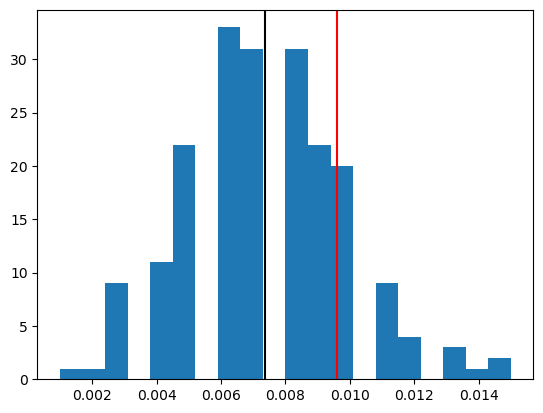

In [26]:
_ = plt.hist(stat, bins=20)
plt.axvline(p, color="red")
plt.axvline(np.mean(stat), color="black")

In [ ]:
m_perm, p_perm = permutation_median_test(g1, g2, n_perm=50000)
p_perm

In [27]:
np.mean(g1), np.mean(g2)

(210.3409457525685, -223.23946491086411)

In [28]:
stat, p_perm = permutation_median_test(g1, g2, n_perm=1000)

In [29]:
n1, n2 = len(g1), len(g2)

In [47]:
from pvalue_metric import metric
p_metric_neq = metric.pvalue_test([g1, g2], stats.ttest_ind, 200, 1000, **{"equal_var":False})[0][0]
p_metric_eq = metric.pvalue_test([g1, g2], stats.ttest_ind, 200, 1000, **{"equal_var":True})[0][0]

In [54]:
def pvalue_for_selected_test(g1, g2, n_boot=200, n_perm=10000, test=stats.ttest_ind, **kwargs):

    _, p = test(g1, g2, **kwargs)

    
    p_median = permutation_median_test(g1, g2, 5000)[1]
    

    p_metric_neq = metric.pvalue_test([g1, g2], test, n_boot, n_perm, **kwargs)[0][0]
    
    return [p, p_median, p_metric_neq]


In [67]:
pvalues = [pvalue_for_selected_test(g1, g2, n_boot=200, n_perm=10000, test=stats.ttest_ind, equal_var=False)]
g1_without_max, g2_witout_min = g1, g2

while any(cell < 0.05 for cell in pvalues[-1]):

    g1_without_max, g2_witout_min = g1.drop(g1_without_max.idxmax()), g2_witout_min.drop(g2_witout_min.idxmin())

    pvalues.append(pvalue_for_selected_test(g1_without_max, g2_witout_min, n_boot=200, n_perm=10000, test=stats.ttest_ind, equal_var=False))

/home/niusha/anaconda3/envs/py11/lib/python3.11/site-packages/pvalue_metric/metric.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_values[bootstrap_itr] = Hypothesis_testing_func(G1_bootstraps[bootstrap_itr],\


In [61]:
# p = pvalues

In [68]:
pvalues

[[0.009584702773021278, 0.0098, 0.007099999999999995],
 [0.030605403862831917, 0.0194, 0.03469999999999995],
 [0.06203088332415935, 0.0282, 0.04490000000000005],
 [0.14304435223612047, 0.0636, 0.17500000000000004]]

In [69]:
n_bootstap = 200
n_permutation =5000
g1_bootstarpes = [np.random.choice(g1, len(g1)) for _ in range(n_bootstap)]
g2_bootstarpes = [np.random.choice(g2, len(g2)) for _ in range(n_bootstap)]

p_boot = [stats.ttest_ind(g1_bootstarpes[i], g2_bootstarpes[i], equal_var=False)[1] for i in range(n_bootstap)]
p_median_boot = [permutation_median_test(g1_bootstarpes[i], g2_bootstarpes[i], n_permutation)[1] for i in range(n_bootstap)]

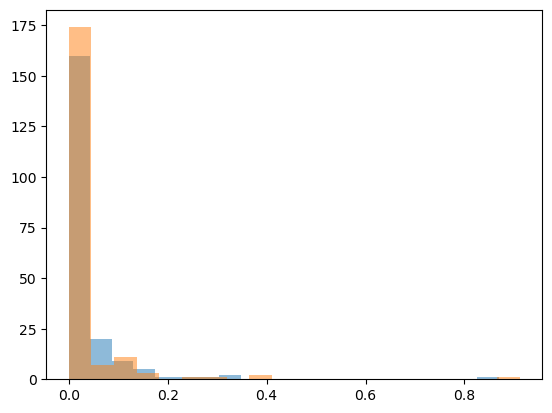

In [ ]:
plt.hist(p_boot, bins=20, alpha=0.5)
plt.hist(p_median_boot, bins=20, alpha=0.5)
plt.show()

In [70]:
np.sum(np.array(p_boot) < 0.05), np.sum(np.array(p_median_boot) < 0.05)

(170, 179)

In [71]:
g1_clipped = stats.sigmaclip(g1, low=3, high=3)[0]
g2_clipped = stats.sigmaclip(g2, low=3, high=3)[0]

pvalues_clipped = pvalue_for_selected_test(g1_clipped, g2_clipped, n_boot=200, n_perm=5000, test=stats.ttest_ind, equal_var=False)
pvalues_clipped

[0.014448690168784674, 0.0076, 0.013399999999999967]

In [72]:
g1_bootstarpes_clipped = [np.random.choice(g1_clipped, len(g1_clipped)) for _ in range(n_bootstap)]
g2_bootstarpes_clipped = [np.random.choice(g2_clipped, len(g2_clipped)) for _ in range(n_bootstap)]

p_boot_clipped = [stats.ttest_ind(g1_bootstarpes_clipped[i], g2_bootstarpes_clipped[i], equal_var=False)[1] for i in range(n_bootstap)]
p_median_boot_clipped = [permutation_median_test(g1_bootstarpes_clipped[i], g2_bootstarpes_clipped[i], n_permutation)[1] for i in range(n_bootstap)]

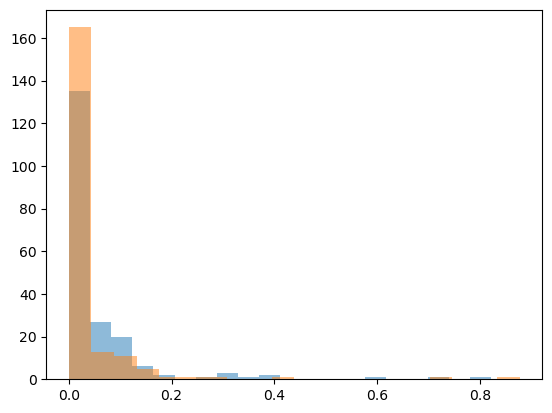

In [74]:
plt.hist(p_boot_clipped, bins=20, alpha=0.5)
plt.hist(p_median_boot_clipped, bins=20, alpha=0.5)
plt.show()

In [ ]:
np.sum(np.array(p_boot_clipped) < 0.05), np.sum(np.array(p_median_boot) < 0.05)

In [ ]:
stats_boot = [stats.ttest_ind(g1_bootstarpes[i], g2_bootstarpes[i], equal_var=False) for i in range(n_bootstap)]

In [ ]:
t_boot = [stat[0] for stat in stats_boot]
p_boot = [stat[1] for stat in stats_boot]

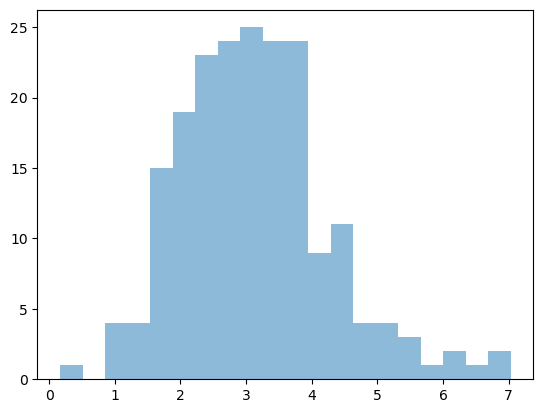

In [ ]:
_ = plt.hist(t_boot, bins=20, alpha=0.5)

In [ ]:
# all_ = stats.ttest_ind(g1, g2, equal_var=False)
# all_.df

22.258674563270528

In [ ]:
from scipy.stats import t as t_
prcs = np.percentile(t_boot, [2.5, 97.5]) 
p_value_up = 2 * (1 - t_.cdf(prcs[0], df=all_.df))
p_value_down = 2 * (1 - t_.cdf(prcs[1], df=all_.df))

In [ ]:
p_value_down, p_value_up

(1.6090637511956274e-05, 0.21909386518611096)

In [ ]:
prcs_p = np.percentile(p_boot, [2.5, 97.5])
prcs_p

array([3.02639874e-05, 2.23042058e-01])

In [ ]:
prcs_p_median = np.percentile(p_median_boot, [2.5, 97.5])
prcs_p_median

array([0.      , 0.344125])

In [ ]:
d = all_.statistic / np.sqrt(all_.df)
d

0.6007457979684057